# 3D Nuclear Segmentation with Mask-RCNN

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HEK293.trks'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.tracked.hek293.load_tracked_data(
    filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (233, 30, 135, 160, 1)
y.shape: (233, 30, 135, 160, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'mrcnn_movie_model'
backbone = 'resnet50'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 20  # Number of training epochs
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 8

num_classes = 1  # "object" is the only class

In [6]:
import tensorflow as tf
import tensorflow.keras.backend as K
from deepcell.losses import smooth_l1
from deepcell.utils.retinanet_anchor_utils import overlap


def focal(y_true, y_pred, alpha=0.25, gamma=2.0, axis=None):
    """Compute the focal loss given the target tensor and the predicted tensor.

    As defined in https://arxiv.org/abs/1708.02002

    Args:
        y_true: Tensor of target data with shape (B, N, num_classes).
        y_pred: Tensor of predicted data with shape (B, N, num_classes).
        alpha: Scale the focal weight with alpha.
        gamma: Take the power of the focal weight with gamma.

    Returns:
        The focal loss of y_pred w.r.t. y_true.
    """
    if axis is None:
        axis = 1 if K.image_data_format() == 'channels_first' else K.ndim(y_pred) - 1

    # compute the focal loss
    alpha_factor = K.ones_like(y_true) * alpha
    alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
    focal_weight = tf.where(K.equal(y_true, 1), 1 - y_pred, y_pred)
    focal_weight = alpha_factor * focal_weight ** gamma

    cls_loss = focal_weight * K.binary_crossentropy(y_true, y_pred)

    return K.sum(cls_loss, axis=axis)

class RetinaNetLosses(object):
    def __init__(self, sigma=3.0, alpha=0.25, gamma=2.0,
                 iou_threshold=0.5, fdl_iou_threshold=0.5,
                 mask_size=(28, 28),
                 parallel_iterations=32):
        self.sigma = sigma
        self.alpha = alpha
        self.gamma = gamma
        self.iou_threshold = iou_threshold
        self.fdl_iou_threshold = fdl_iou_threshold
        self.mask_size = mask_size
        self.parallel_iterations = parallel_iterations

    def regress_loss(self, y_true, y_pred):
        # separate target and state
        regression = y_pred
        regression_target = y_true[..., :-1]
        anchor_state = y_true[..., -1]

        # filter out "ignore" anchors
        indices = tf.where(K.equal(anchor_state, 1))
        regression = tf.gather_nd(regression, indices)
        regression_target = tf.gather_nd(regression_target, indices)

        # compute the loss
        loss = smooth_l1(regression_target, regression, sigma=self.sigma)

        # compute the normalizer: the number of positive anchors
        normalizer = K.maximum(1, K.shape(indices)[0])
        normalizer = K.cast(normalizer, dtype=K.floatx())

        return K.sum(loss) / normalizer

    def classification_loss(self, y_true, y_pred):
        # TODO: try weighted_categorical_crossentropy
        labels = y_true[..., :-1]
        # -1 for ignore, 0 for background, 1 for object
        anchor_state = y_true[..., -1]

        classification = y_pred
        # filter out "ignore" anchors
        indices = tf.where(K.not_equal(anchor_state, -1))
        labels = tf.gather_nd(labels, indices)
        classification = tf.gather_nd(classification, indices)

        # compute the loss
        loss = focal(labels, classification, alpha=self.alpha, gamma=self.gamma)

        # compute the normalizer: the number of positive anchors
        normalizer = tf.where(K.equal(anchor_state, 1))
        normalizer = K.cast(K.shape(normalizer)[0], K.floatx())
        normalizer = K.maximum(K.cast_to_floatx(1.0), normalizer)

        return K.sum(loss) / normalizer

    def mask_loss(self, y_true, y_pred):
        def _mask_conditional(y_true, y_pred):
            # if there are no masks annotations, return 0; else, compute the masks loss
            return tf.cond(
                K.any(K.equal(K.shape(y_true), 0)),
                lambda: K.cast_to_floatx(0.0),
                lambda: _mask_batch(y_true, y_pred,
                                    iou_threshold=self.iou_threshold,
                                    mask_size=self.mask_size,
                                    parallel_iterations=self.parallel_iterations)
            )

        def _mask_batch(y_true, y_pred,
                        iou_threshold=0.5,
                        mask_size=(28, 28),
                        parallel_iterations=32):
            if K.ndim(y_pred) == 4:
                y_pred_shape = tf.shape(y_pred)
                new_y_pred_shape = [y_pred_shape[0] * y_pred_shape[1],
                                    y_pred_shape[2], y_pred_shape[3]]
                y_pred = tf.reshape(y_pred, new_y_pred_shape)

                y_true_shape = tf.shape(y_true)
                new_y_true_shape = [y_true_shape[0] * y_true_shape[1],
                                    y_true_shape[2], y_true_shape[3]]
                y_true = tf.reshape(y_true, new_y_true_shape)

            # split up the different predicted blobs
            boxes = y_pred[:, :, :4]
            masks = y_pred[:, :, 4:]

            # split up the different blobs
            annotations = y_true[:, :, :5]
            width = K.cast(y_true[0, 0, 5], dtype='int32')
            height = K.cast(y_true[0, 0, 6], dtype='int32')
            masks_target = y_true[:, :, 7:]

            # reshape the masks back to their original size
            masks_target = K.reshape(masks_target, (K.shape(masks_target)[0],
                                                    K.shape(masks_target)[1],
                                                    height, width))
            masks = K.reshape(masks, (K.shape(masks)[0], K.shape(masks)[1],
                                      mask_size[0], mask_size[1], -1))

            def _mask(args):
                boxes = args[0]
                masks = args[1]
                annotations = args[2]
                masks_target = args[3]

                return compute_mask_loss(
                    boxes,
                    masks,
                    annotations,
                    masks_target,
                    width,
                    height,
                    iou_threshold=iou_threshold,
                    mask_size=mask_size,
                )

            mask_batch_loss = tf.map_fn(
                _mask,
                elems=[boxes, masks, annotations, masks_target],
                dtype=K.floatx(),
                parallel_iterations=parallel_iterations
            )
            return K.mean(mask_batch_loss)

        return _mask_conditional(y_true, y_pred)

    def final_detection_loss(self, y_true, y_pred):

        def _fd_batch(y_true, y_pred, iou_threshold=0.75, parallel_iterations=32):
            if K.ndim(y_pred) == 4:
                y_pred_shape = K.shape(y_pred)
                new_y_pred_shape = [y_pred_shape[0] * y_pred_shape[1],
                                    y_pred_shape[2], y_pred_shape[3]]
                y_pred = K.reshape(y_pred, new_y_pred_shape)

                y_true_shape = K.shape(y_true)
                new_y_true_shape = [y_true_shape[0] * y_true_shape[1],
                                    y_true_shape[2], y_true_shape[3]]
                y_true = K.reshape(y_true, new_y_true_shape)

            # split up the different predicted blobs
            boxes = y_pred[:, :, :4]
            scores = y_pred[:, :, 4:5]

            # split up the different blobs
            annotations = y_true[:, :, :5]

            def _fd(args):
                boxes = args[0]
                scores = args[1]
                annotations = args[2]

                return compute_fd_loss(
                    boxes,
                    scores,
                    annotations,
                    iou_threshold=iou_threshold)

            fd_batch_loss = tf.map_fn(
                _fd,
                elems=[boxes, scores, annotations],
                dtype=K.floatx(),
                parallel_iterations=parallel_iterations)

            meanloss = K.mean(fd_batch_loss)
            return meanloss

        return tf.cond(
            K.any(K.equal(K.shape(y_true), 0)),
            lambda: K.cast_to_floatx(0),
            lambda: _fd_batch(
                y_true, y_pred,
                iou_threshold=self.fdl_iou_threshold,
                parallel_iterations=self.parallel_iterations))


def compute_mask_loss(boxes,
                      masks,
                      annotations,
                      masks_target,
                      width,
                      height,
                      iou_threshold=0.5,
                      mask_size=(28, 28)):
    """compute overlap of boxes with annotations"""
    iou = overlap(boxes, annotations)
    argmax_overlaps_inds = K.argmax(iou, axis=1)
    max_iou = K.max(iou, axis=1)

    # filter those with IoU > 0.5
    indices = tf.where(K.greater_equal(max_iou, iou_threshold))
    boxes = tf.gather_nd(boxes, indices)
    masks = tf.gather_nd(masks, indices)
    argmax_overlaps_inds = K.cast(tf.gather_nd(argmax_overlaps_inds, indices), 'int32')
    labels = K.cast(K.gather(annotations[:, 4], argmax_overlaps_inds), 'int32')

    # make normalized boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    boxes = K.stack([
        y1 / (K.cast(height, dtype=K.floatx()) - 1),
        x1 / (K.cast(width, dtype=K.floatx()) - 1),
        (y2 - 1) / (K.cast(height, dtype=K.floatx()) - 1),
        (x2 - 1) / (K.cast(width, dtype=K.floatx()) - 1),
    ], axis=1)

    # crop and resize masks_target
    # append a fake channel dimension
    masks_target = K.expand_dims(masks_target, axis=3)
    masks_target = tf.image.crop_and_resize(
        masks_target,
        boxes,
        argmax_overlaps_inds,
        mask_size
    )
    masks_target = masks_target[:, :, :, 0]  # remove fake channel dimension

    # gather the predicted masks using the annotation label
    masks = tf.transpose(masks, (0, 3, 1, 2))
    label_indices = K.stack([tf.range(K.shape(labels)[0]), labels], axis=1)

    masks = tf.gather_nd(masks, label_indices)

    # compute mask loss
    mask_loss = K.binary_crossentropy(masks_target, masks)
    normalizer = K.shape(masks)[0] * K.shape(masks)[1] * K.shape(masks)[2]
    normalizer = K.maximum(K.cast(normalizer, K.floatx()), 1)
    mask_loss = K.sum(mask_loss) / normalizer

    return mask_loss


def compute_fd_loss(boxes, scores, annotations, iou_threshold=0.75):
    """compute the overlap of boxes with annotations"""
    iou = overlap(boxes, annotations)
    max_iou = K.max(iou, axis=1, keepdims=True)
    targets = K.cast(K.greater_equal(max_iou, iou_threshold), K.floatx())
    # compute the loss
    loss = focal(targets, scores)  # alpha=self.alpha, gamma=self.gamma)
    # compute the normalizer: the number of cells present in the image
    normalizer = K.cast(K.shape(annotations)[0], K.floatx())
    normalizer = K.maximum(K.cast_to_floatx(1.0), normalizer)

    return K.sum(loss) / normalizer


In [7]:
# Each head of the model uses its own loss
from deepcell import losses

sigma = 3.0
alpha = 0.25
gamma = 2.0
iou_threshold = 0.5
mask_size = (28, 28)

retinanet_losses = losses.RetinaNetLosses(
    sigma=sigma,
    alpha=alpha,
    gamma=gamma,
    iou_threshold=iou_threshold,
    mask_size=mask_size)

loss = {
    'regression': retinanet_losses.regress_loss,
    'classification': retinanet_losses.classification_loss,
    'masks': retinanet_losses.mask_loss,
    'final_detection': retinanet_losses.final_detection_loss
}

## Create the RetinaMovieMask Model

In [8]:
from deepcell.utils.retinanet_anchor_utils import generate_anchor_params

backbone_levels = ['C1', 'C2', 'C3', 'C4', 'C5']
pyramid_levels = ['P2', 'P3']
anchor_size_dict = {'P2': 16, 'P3': 32}

anchor_params = generate_anchor_params(pyramid_levels, anchor_size_dict)

fpb = 5  # number of frames in each training batch

In [9]:
from deepcell import model_zoo

# Pass frames_per_batch > 1 to enable 3D mode!
model = model_zoo.RetinaMask(
    backbone=backbone,
    use_imagenet=False,
    panoptic=False,
    frames_per_batch=fpb,
    num_classes=num_classes,
    input_shape=X_train.shape[2:],
    anchor_params=anchor_params,
    class_specific_filter=False,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels)

In [10]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

In [11]:
from deepcell.image_generators import RetinaMovieDataGenerator

datagen = RetinaMovieDataGenerator(
    rotation_range=180,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = RetinaMovieDataGenerator()

In [12]:
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    batch_size=1,
    include_masks=True,
    include_final_detection_layer=True,
    frames_per_batch=fpb,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    batch_size=1,
    include_masks=True,
    include_final_detection_layer=True,
    frames_per_batch=fpb,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

In [13]:
from tensorflow.keras import callbacks

model.fit_generator(
    train_data,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=X_test.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            os.path.join(MODEL_DIR, model_name + '.h5'),
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            save_weights_only=False)
    ])

Epoch 1/20


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


28/29 [===========================>..] - ETA: 2s - loss: 4.8341 - regression_loss: 2.9379 - classification_loss: 1.1135 - masks_loss: 0.0000e+00 - final_detection_loss: 0.7828
Epoch 00001: val_loss improved from inf to 4.61031, saving model to /data/models/mrcnn_movie_model.h5
29/29 [==============================] - 77s 3s/step - loss: 4.8247 - regression_loss: 2.9336 - classification_loss: 1.1117 - masks_loss: 0.0000e+00 - final_detection_loss: 0.7794 - val_loss: 4.6103 - val_regression_loss: 2.8196 - val_classification_loss: 1.0567 - val_masks_loss: 0.0000e+00 - val_final_detection_loss: 0.7340
Epoch 2/20
28/29 [===========================>..] - ETA: 0s - loss: 4.7464 - regression_loss: 2.7321 - classification_loss: 0.8406 - masks_loss: 0.4578 - final_detection_loss: 0.7159
Epoch 00002: val_loss improved from 4.61031 to 4.57113, saving model to /data/models/mrcnn_movie_model.h5
29/29 [==============================] - 16s 553ms/step - loss: 4.7359 - regression_loss: 2.7307 - classif

Epoch 15/20
28/29 [===========================>..] - ETA: 0s - loss: 3.2764 - regression_loss: 2.2278 - classification_loss: 0.3411 - masks_loss: 0.5168 - final_detection_loss: 0.1906
Epoch 00015: val_loss improved from 3.15998 to 3.05078, saving model to /data/models/mrcnn_movie_model.h5
29/29 [==============================] - 16s 553ms/step - loss: 3.2691 - regression_loss: 2.2240 - classification_loss: 0.3416 - masks_loss: 0.5146 - final_detection_loss: 0.1889 - val_loss: 3.0508 - val_regression_loss: 2.0519 - val_classification_loss: 0.3338 - val_masks_loss: 0.4866 - val_final_detection_loss: 0.1785
Epoch 16/20
28/29 [===========================>..] - ETA: 0s - loss: 3.2243 - regression_loss: 2.1782 - classification_loss: 0.3479 - masks_loss: 0.4930 - final_detection_loss: 0.2052
Epoch 00016: val_loss improved from 3.05078 to 2.98879, saving model to /data/models/mrcnn_movie_model.h5
29/29 [==============================] - 16s 552ms/step - loss: 3.2242 - regression_loss: 2.1802 -

## Evaluate results

In [14]:
from deepcell import model_zoo

prediction_model = model_zoo.RetinaMask(
    backbone=backbone,
    use_imagenet=False,
    panoptic=False,
    frames_per_batch=fpb,
    num_classes=num_classes,
    input_shape=X_test.shape[2:],
    class_specific_filter=True,
    anchor_params=anchor_params,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels)

prediction_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [15]:
from deepcell.utils.retinanet_anchor_utils import evaluate_mask

iou_threshold = 0.5
score_threshold = 0.01
max_detections = 100

average_precisions = evaluate_mask(
    val_data,
    prediction_model,
    frames_per_batch=fpb,
    iou_threshold=iou_threshold,
    score_threshold=score_threshold,
    max_detections=max_detections,
)

# print evaluation
total_instances = []
precisions = []

for label, (average_precision, num_annotations) in average_precisions.items():
    print('{:.0f} instances of class'.format(num_annotations),
          label, 'with average precision: {:.4f}'.format(average_precision))
    total_instances.append(num_annotations)
    precisions.append(average_precision)

if sum(total_instances) == 0:
    print('No test instances found.')
else:
    print('mAP using the weighted average of precisions among classes: {:.4f}'.format(
        sum([a * b for a, b in zip(total_instances, precisions)]) / sum(total_instances)))
    print('mAP: {:.4f}'.format(sum(precisions) / sum(x > 0 for x in total_instances)))

374 instances of class 0 with average precision: 0.0087
mAP using the weighted average of precisions among classes: 0.0087
mAP: 0.0087


## Display results

Image Number: 12
Frame Number: 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


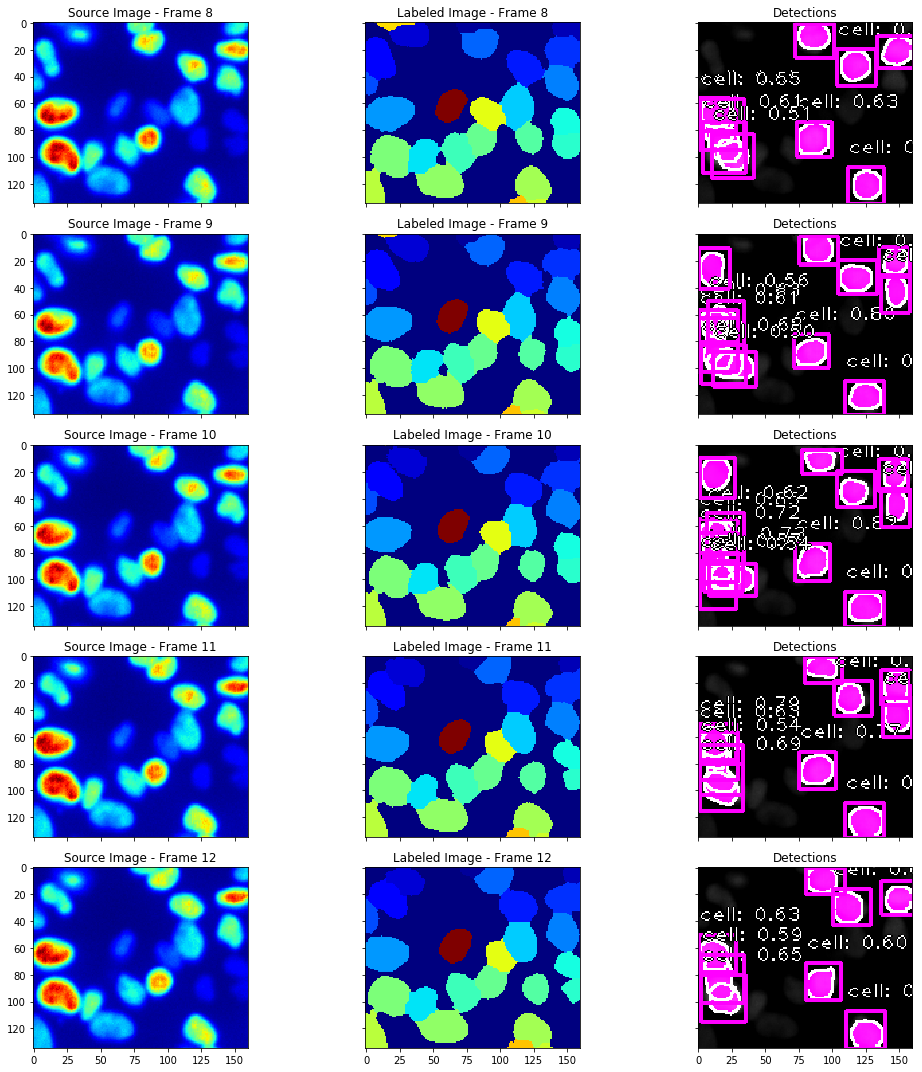

In [17]:
import matplotlib.pyplot as plt
import os
import time
import cv2
import numpy as np
from deepcell.utils.plot_utils import draw_masks, draw_box

index = np.random.randint(low=0, high=X_test.shape[0])
frame = np.random.randint(low=0, high=X_test.shape[1] - fpb)

print('Image Number:', index)
print('Frame Number:', frame)

image = X_test[index:index + 1, frame:frame + fpb]
gt_mask = y_test[index:index + 1, frame:frame + fpb]

outputs = prediction_model.predict(image)
boxes = outputs[-5]
scores = outputs[-4]
labels = outputs[-3]
masks = outputs[-2]
final_scores = outputs[-1]

display = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
gt_mask = np.squeeze(gt_mask)

draw_list = []

for i in range(fpb):
    draw = 0.1 * np.tile(image[0, i].copy(), (1, 1, 3))

    selection = np.where(final_scores[0, i] > 0.75)[0]

    # draw the masks
    draw_masks(draw, boxes[0, i], scores[0, i], masks[0, i],
               score_threshold=0.5, binarize_threshold=0.5)

    # draw detections
    deepcell.utils.plot_utils.draw_detections(
        draw, boxes[0, i], scores[0, i], labels[0, i],
        label_to_name=lambda x: 'cell', score_threshold=0.5)

    draw_list.append(draw)

fig, axes = plt.subplots(ncols=3, nrows=fpb, figsize=(15, 15), sharex=True, sharey=True)
for i in range(fpb):
    axes[i, 0].imshow(display[i, ..., 0], cmap='jet')
    axes[i, 0].set_title('Source Image - Frame {}'.format(frame + i))

    axes[i, 1].imshow(gt_mask[i], cmap='jet')
    axes[i, 1].set_title('Labeled Image - Frame {}'.format(frame + i))

    axes[i, 2].imshow(draw_list[i], cmap='jet')
    axes[i, 2].set_title('Detections')

fig.tight_layout()
plt.show()

fig.tight_layout()
plt.show()